## Download the Data

In [3]:
!kaggle competitions download house-prices-advanced-regression-techniques

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
!ls

00-download-injest-split-data.ipynb second.csv
data_description.txt                seventh.csv
eighth.csv                          sixth.csv
eleventh.csv                        tenth.csv
fifth.csv                           test.csv
first.csv                           third.csv
forth.csv                           train.csv
nineth.csv                          train_evaluate-Copy1.ipynb
sample_submission.csv


In [3]:
import os
print(os.getcwd())

/Users/val/house-prices-regression


In [4]:
#dataset is located in current directory
HOUSING_PATH = os.getcwd()

#function to load training dataset
import pandas as pd
def load_housing_data(filename ="train.csv" ):
    csv_path=os.path.join(HOUSING_PATH, filename)
    return pd.read_csv(csv_path, index_col =0)


## Take a Quick Look at the Data Structure

In [5]:
#load trainig dataset
housing = load_housing_data()
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [230]:
#load test dataset
housing_test = load_housing_data("test.csv")


In [231]:
housing_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 

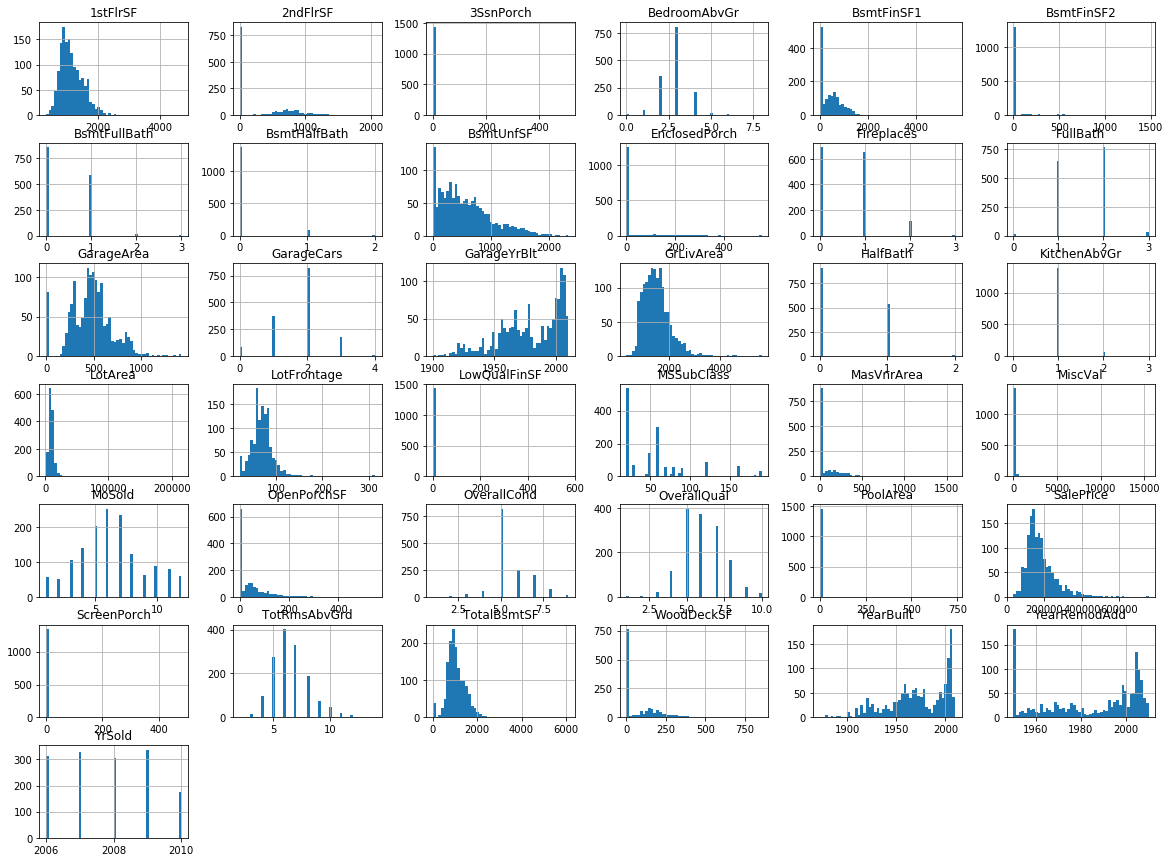

In [8]:
# display histogram for each numerical attribute
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Create a Test Set

Suppose 1stFlrSF (or GrLivArea) is very important attribute to predict housing sale prices. You  may want to ensure that the test set is representative of the varios categories of square footage in the whole dataset. This is called stratified sampling. 

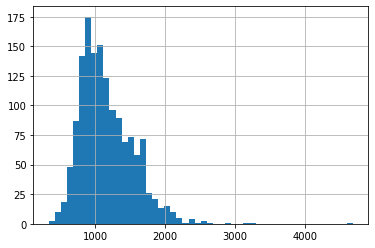

In [9]:
housing["1stFlrSF"].hist(bins=50)

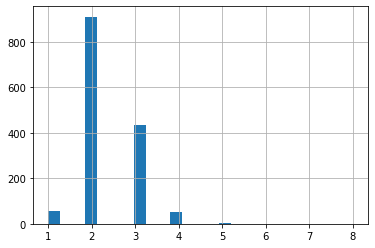

In [10]:
import numpy as np
housing["1stFlrSF_cat"]= np.ceil(housing["1stFlrSF"] / 630)
housing["1stFlrSF_cat"].hist(bins=25)
#housing["1stFlrSF_cat"].where(housing["1stFlrSF_cat"] > 5, 5.0, inplace = True )

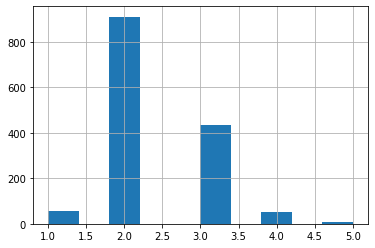

In [11]:
housing["1stFlrSF_cat"].where(housing["1stFlrSF_cat"] < 4.5, 5.0, inplace = True )
housing["1stFlrSF_cat"].hist()

In [12]:
# apply stratified sampling based on 1stFlrSF category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["1stFlrSF_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Now we should remove the 1stFlrSF_cat attribute so the data is back to its original state

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("1stFlrSF_cat", axis=1, inplace=True)

In [14]:
housing = strat_train_set.copy()

## Discover and Visualize Data to Gain Insights

### Looking for correlations

In [15]:
# how much each attribute correlates with SalePrice
corr_matrix = housing.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.792689
GrLivArea        0.707640
GarageCars       0.647421
GarageArea       0.632419
1stFlrSF         0.612033
TotalBsmtSF      0.610192
FullBath         0.555087
YearBuilt        0.522702
TotRmsAbvGrd     0.519637
YearRemodAdd     0.503269
GarageYrBlt      0.486172
Fireplaces       0.470867
MasVnrArea       0.447203
BsmtFinSF1       0.398613
LotFrontage      0.340821
OpenPorchSF      0.336434
WoodDeckSF       0.314760
2ndFlrSF         0.305790
HalfBath         0.289217
LotArea          0.246071
BsmtFullBath     0.240223
BsmtUnfSF        0.191165
BedroomAbvGr     0.144932
PoolArea         0.098967
ScreenPorch      0.076703
MoSold           0.058681
3SsnPorch        0.033347
LowQualFinSF    -0.020303
MiscVal         -0.022011
BsmtFinSF2      -0.022586
BsmtHalfBath    -0.023122
YrSold          -0.029817
MSSubClass      -0.078315
OverallCond     -0.080641
EnclosedPorch   -0.112048
KitchenAbvGr    -0.131329
Name: SalePrice, dtype: float64

NameError: name 'save_fig' is not defined

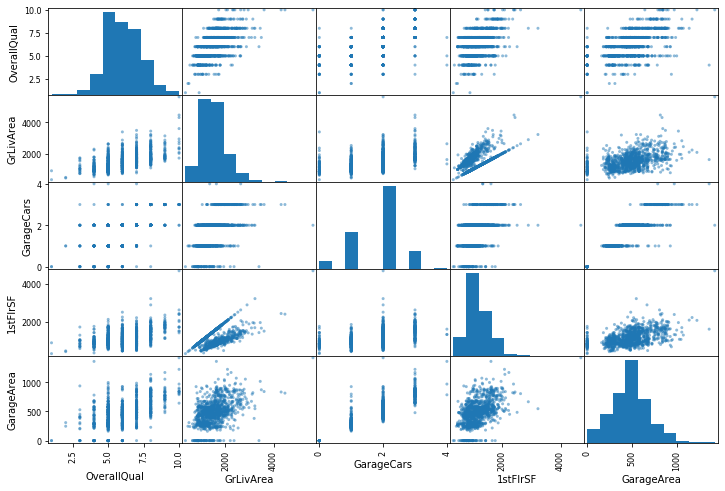

In [16]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["OverallQual", "GrLivArea", "GarageCars",
              "1stFlrSF", "GarageArea"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

The most promising attribute to predict the house SalePrice is GrLivArea, so let's zoom in on their correlation scatterplot

In [ ]:
# correlation scatterplot
housing.plot(kind="scatter", x="GrLivArea", y="SalePrice",
             alpha=0.1)
#plt.axis([0, 16, 0, 550000])
#save_fig("income_vs_house_value_scatterplot")

In [ ]:
import seaborn as sns
sns.pairplot(housing[["GrLivArea", "SalePrice"]])

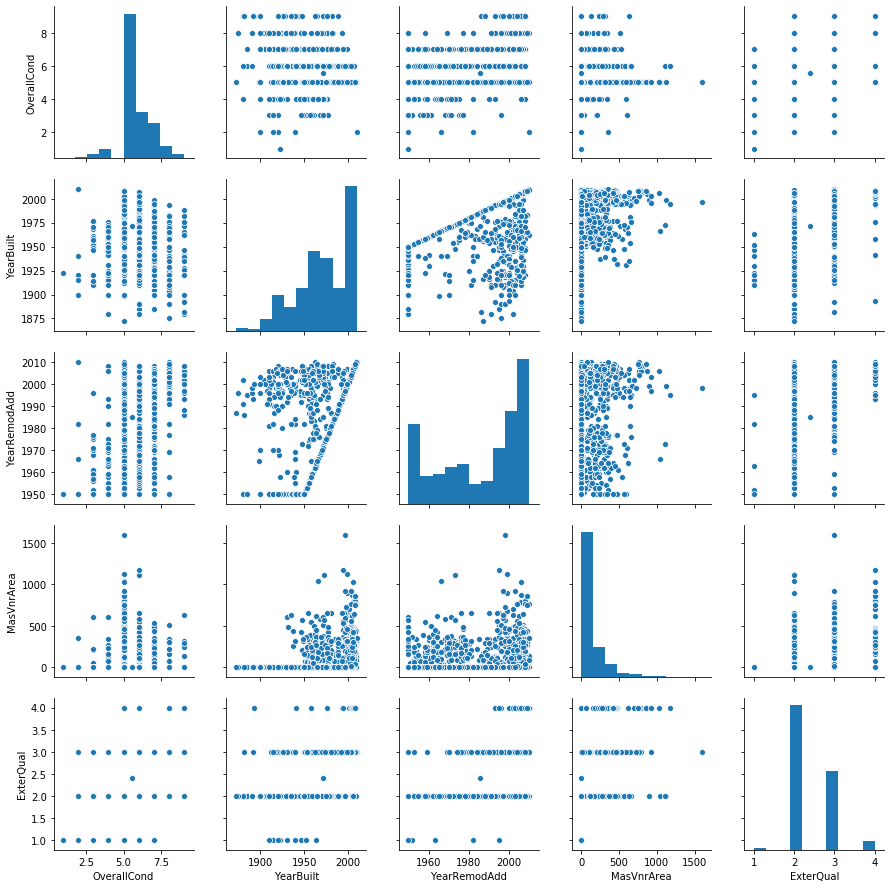

In [343]:
sns.pairplot(housing_num.iloc[:,5:10])

housing_num

The plot reveals that correlation is indeed very strong.

## Experimenting with Attribute Combinations

In [17]:
corr_matrix = housing.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.792689
GrLivArea        0.707640
GarageCars       0.647421
GarageArea       0.632419
1stFlrSF         0.612033
TotalBsmtSF      0.610192
FullBath         0.555087
YearBuilt        0.522702
TotRmsAbvGrd     0.519637
YearRemodAdd     0.503269
GarageYrBlt      0.486172
Fireplaces       0.470867
MasVnrArea       0.447203
BsmtFinSF1       0.398613
LotFrontage      0.340821
OpenPorchSF      0.336434
WoodDeckSF       0.314760
2ndFlrSF         0.305790
HalfBath         0.289217
LotArea          0.246071
BsmtFullBath     0.240223
BsmtUnfSF        0.191165
BedroomAbvGr     0.144932
PoolArea         0.098967
ScreenPorch      0.076703
MoSold           0.058681
3SsnPorch        0.033347
LowQualFinSF    -0.020303
MiscVal         -0.022011
BsmtFinSF2      -0.022586
BsmtHalfBath    -0.023122
YrSold          -0.029817
MSSubClass      -0.078315
OverallCond     -0.080641
EnclosedPorch   -0.112048
KitchenAbvGr    -0.131329
Name: SalePrice, dtype: float64

In [18]:
#lets create some new attributes
#housing["garage_cars_per_bedroom"] = housing["GarageCars"]/housing["BedroomAbvGr"]
#housing["bedrooms_per_room"] = housing["BedroomAbvGr"]/housing["TotRmsAbvGrd"]
#housing["bathrooms_per_bedroom"]=housing["FullBath"]/housing["BedroomAbvGr"]


In [19]:
corr_matrix = housing.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.792689
GrLivArea        0.707640
GarageCars       0.647421
GarageArea       0.632419
1stFlrSF         0.612033
TotalBsmtSF      0.610192
FullBath         0.555087
YearBuilt        0.522702
TotRmsAbvGrd     0.519637
YearRemodAdd     0.503269
GarageYrBlt      0.486172
Fireplaces       0.470867
MasVnrArea       0.447203
BsmtFinSF1       0.398613
LotFrontage      0.340821
OpenPorchSF      0.336434
WoodDeckSF       0.314760
2ndFlrSF         0.305790
HalfBath         0.289217
LotArea          0.246071
BsmtFullBath     0.240223
BsmtUnfSF        0.191165
BedroomAbvGr     0.144932
PoolArea         0.098967
ScreenPorch      0.076703
MoSold           0.058681
3SsnPorch        0.033347
LowQualFinSF    -0.020303
MiscVal         -0.022011
BsmtFinSF2      -0.022586
BsmtHalfBath    -0.023122
YrSold          -0.029817
MSSubClass      -0.078315
OverallCond     -0.080641
EnclosedPorch   -0.112048
KitchenAbvGr    -0.131329
Name: SalePrice, dtype: float64

The new garage_cars_per_bedroom attribute is more correleated with the house SalePrice than the BedroomAbvGr attribute. Aslo bathrooms_per_bedroom attribute is more correlated than BedroomAbvGr with the target, as well as bedrooms_per_room is more correlated than BedroomAbvGr.

## Prepare Data for Machine Learning Algorithms

Let's revert to a clean training set and let's separate the predictors and the labels since we do not want to apply same transformations to the predictors and the target value

In [20]:
housing = strat_train_set.drop(["SalePrice"], axis=1) # drop labels for training set
housing_labels = strat_train_set["SalePrice"].copy()

### Data Cleaning

First, lets convert ordinal attributes to numeric format

We noticed that some attributes have missing values, so lets fix this

In [21]:
missing_columns = housing.columns[housing.isna().any()].tolist()

In [22]:
#listing columns with missing values
housing[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 791 to 737
Data columns (total 79 columns):
MSSubClass       1167 non-null float64
MSZoning         1167 non-null object
LotFrontage      956 non-null float64
LotArea          1167 non-null float64
Street           1167 non-null object
Alley            75 non-null object
LotShape         1167 non-null object
LandContour      1167 non-null object
Utilities        1167 non-null object
LotConfig        1167 non-null object
LandSlope        1167 non-null object
Neighborhood     1167 non-null object
Condition1       1167 non-null object
Condition2       1167 non-null object
BldgType         1167 non-null object
HouseStyle       1167 non-null object
OverallQual      1167 non-null float64
OverallCond      1167 non-null float64
YearBuilt        1167 non-null float64
YearRemodAdd     1167 non-null float64
RoofStyle        1167 non-null object
RoofMatl         1167 non-null object
Exterior1st      1167 non-null object
Exterior2nd   

We see that among numeric columns only LotFrontage (impute with mean), MasVnrArea (impute with 0 ), GarageYrBlt (impute with mean) have missing values.

Lets separate numerical attributes

In [23]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameImputer(BaseEstimator, TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with "NA" value 
        in column.

        Columns of other types are imputed with mean of column,

        """
    def fit(self, X, y=None):
        cleanup_nums = {"MasVnrArea": {None: 0},
                "Fence": {"MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4, None: 0},
                "GarageFinish": {"Unf":1, "RFn":2, "Fin":3, None: 0},
                "LotFrontage": {None: 0},
                "GarageYrBlt": {None: 1900},
                        "Alley": {"Grvl": 1, "Pave": 2, None: 0},
                        "PoolQC": {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4, None: 0},
                        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
                        "GarageCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4, None: -1},
                        "GarageQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4, None: -1},               
                        "FireplaceQu": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4, None: -1},                
                        "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},                
                        "CentralAir": {"N": 0, "Y": 1},                
                        "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},               
                        "BsmtFinType2": {"Unf": 0, "LwQ": 1, "Rec": 2, "BLQ": 3, "ALQ": 4, "GLQ": 5, None: -1},                
                        "BsmtFinType1": {"Unf": 0, "LwQ": 1, "Rec": 2, "BLQ": 3, "ALQ": 4, "GLQ": 5, None: -1},                
                        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd":3, None: -1},                
                        "BsmtCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4, None: -1},                
                        "BsmtQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4, None: -1},                
                        "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},                
                        "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},
                       }
        #
        
        X.replace(cleanup_nums, inplace=True)
        
        self.fill = pd.Series(["NA" if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
                              index=X.columns)
        
        
        return self

    def transform(self, X, y=None):        
        #
        r=(X.fillna(self.fill))
        return r
        



In [24]:
# select only numeric columns
#num_attribs = list(housing.select_dtypes(include=[np.number]).columns)
num_attribs = ['MSSubClass',
 'LotFrontage',
 'LotArea',
 'Alley',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold']


#separate categorical attributes
#cat_attribs = list(housing.select_dtypes(exclude=[np.number]).columns)
cat_attribs = ['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'Electrical',
 'Functional',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [25]:

#
housing_num = DataFrameImputer().fit_transform(housing[num_attribs])
housing_cat = DataFrameImputer().fit_transform(housing[cat_attribs])
housing_cat_full = DataFrameImputer().fit_transform(pd.concat([strat_train_set[cat_attribs], strat_test_set[cat_attribs]]))




/anaconda3/envs/py37/lib/python3.6/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [26]:
housing_cat["Utilities"].value_counts()

AllPub    1166
NA           1
NoSeWa       1
Name: Utilities, dtype: int64

In [27]:
#listing columns with missing values
missing_columns = housing_cat.columns[housing_cat.isna().any()].tolist()
housing_cat[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 791 to 737
Empty DataFrame

Notice, that some of the categorical attributes above are actually ordinal rather than nominal. Some additional clean up below is required

### Handling Text and Categorical Attributes

In [28]:
housing_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 791 to 737
Data columns (total 25 columns):
MSZoning         1168 non-null object
Street           1168 non-null object
LotShape         1168 non-null object
LandContour      1168 non-null object
Utilities        1168 non-null object
LotConfig        1168 non-null object
LandSlope        1168 non-null object
Neighborhood     1168 non-null object
Condition1       1168 non-null object
Condition2       1168 non-null object
BldgType         1168 non-null object
HouseStyle       1168 non-null object
RoofStyle        1168 non-null object
RoofMatl         1168 non-null object
Exterior1st      1168 non-null object
Exterior2nd      1168 non-null object
MasVnrType       1168 non-null object
Foundation       1168 non-null object
Heating          1168 non-null object
Electrical       1168 non-null object
Functional       1168 non-null object
GarageType       1168 non-null object
MiscFeature      1168 non-null object
SaleType         1

In [29]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_full)
housing_cat_1hot

<1460x203 sparse matrix of type '<class 'numpy.float64'>'
	with 36500 stored elements in Compressed Sparse Row format>

In [30]:
# save category names for categorical attributes
cat_list = cat_encoder.categories_

In [31]:
housing_cat.shape

(1168, 25)

In [32]:
housing_cat_1hot.shape

(1460, 203)

## Custom Transformers

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X["garage_cars_per_bedroom"] = X["GarageCars"] / (X["BedroomAbvGr"]+ 0.5)
        X["bathrooms_per_bedroom"] = X["FullBath"] / (X["BedroomAbvGr"]+ 0.5)
        if self.add_bedrooms_per_room:
            X["bedrooms_per_room"] = X["BedroomAbvGr"] / X["TotRmsAbvGrd"]
        
        return X.values

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_num)

In [34]:
housing_extra_attribs.shape

(1168, 56)

In [35]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    X["garage_cars_per_bedroom"] = X["GarageCars"] / (X["BedroomAbvGr"]+ 0.5)
    X["bathrooms_per_bedroom"] = X["FullBath"] / (X["BedroomAbvGr"]+ 0.5)
    if add_bedrooms_per_room:
        X["bedrooms_per_room"] = X["BedroomAbvGr"] / X["TotRmsAbvGrd"]
    
    return X.values

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing_num)

In [36]:
housing_extra_attribs.shape

(1168, 56)

In [37]:
housing_extra_attribs

array([[1.20000000e+02, 4.30000000e+01, 3.18200000e+03, ...,
        2.00900000e+03, 8.00000000e-01, 8.00000000e-01],
       [5.00000000e+01, 6.00000000e+01, 1.01340000e+04, ...,
        2.00700000e+03, 4.00000000e-01, 4.00000000e-01],
       [2.00000000e+01, 9.00000000e+01, 1.19880000e+04, ...,
        2.00700000e+03, 2.85714286e-01, 2.85714286e-01],
       ...,
       [2.00000000e+01, 6.30000000e+01, 1.74230000e+04, ...,
        2.00900000e+03, 2.00000000e+00, 1.33333333e+00],
       [2.00000000e+01, 1.30000000e+02, 1.14570000e+04, ...,
        2.00900000e+03, 5.71428571e-01, 5.71428571e-01],
       [9.00000000e+01, 6.00000000e+01, 8.54400000e+03, ...,
        2.00600000e+03, 8.00000000e-01, 8.00000000e-01]])

In [38]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing_num.columns)+["garage_cars_per_bedroom", "bathrooms_per_bedroom"],
    index=housing.index)
housing_extra_attribs.head()

ValueError: Shape of passed values is (1168, 56), indices imply (1168, 58)

## Feature Scaling

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use CombinedAttributesAdder() instead of FunctionTransformer(...) if we preferred):

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', DataFrameImputer()),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing[num_attribs])
housing_num_tr.shape

/anaconda3/envs/py37/lib/python3.6/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


(1168, 57)

In [40]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

cat_pipeline = Pipeline([
        ('imputer', DataFrameImputer()),
        ('cat_encoder', OneHotEncoder(sparse=False, categories=cat_list)),
    ])

housing_cat_tr = cat_pipeline.fit_transform(housing[cat_attribs])

In [41]:
full = pd.concat([strat_train_set[cat_attribs], strat_test_set[cat_attribs]])

In [42]:
housing_cat_tr.shape

(1168, 203)

In [43]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [44]:
housing_prepared.shape

(1168, 260)

In [45]:

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [46]:



from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', DataFrameImputer()),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = old_num_pipeline.fit_transform(housing[num_attribs])
housing_num_tr.shape

(1168, 57)

In [47]:
housing_num_tr = old_num_pipeline.fit_transform(housing[0:5][num_attribs])
housing_num_tr.shape

(5, 57)

In [48]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('imputer', DataFrameImputer()),
        ('cat_encoder', OneHotEncoder(sparse=False , categories=cat_list)),
    ])

housing_cat_tr = old_cat_pipeline.fit_transform(housing.iloc[0:5])

In [49]:
housing_cat_tr.shape

(5, 203)

In [50]:
len(cat_list)

25

In [51]:
cat_encoder.categories_

[array(['C (all)', 'FV', 'NA', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'NA', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'NA', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl', 'NA'], dtype=object),
 array(['AllPub', 'NA', 'NoSeWa'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'NA'], dtype=object),
 array(['Gtl', 'Mod', 'NA', 'Sev'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NA', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt',
        'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr',
        'Timber', 'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'NA', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn',
        'RRNe', 'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'NA', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn',
        'RRNn'], dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'NA', 'Twnhs', 

In [52]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", old_num_pipeline),
    ("cat_pipeline", old_cat_pipeline),
])

In [53]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared.shape

/anaconda3/envs/py37/lib/python3.6/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


(1168, 260)

In [54]:
np.isnan(housing_labels).any()

True

In [55]:
# fill missing label values with mean column values
housing_labels.fillna(housing_labels.mean(), inplace=True)  

housing_labels[housing_labels.index==0]

Id
0    181377.812339
Name: SalePrice, dtype: float64

In [232]:
#strat_train_set, strat_test_set
X_train = housing_prepared
y_train = housing_labels

X_val = full_pipeline.fit_transform(strat_test_set.drop("SalePrice", axis=1))
y_val = strat_test_set["SalePrice"]

X = full_pipeline.fit_transform(pd.concat([strat_train_set, strat_test_set]))
y = pd.concat([housing_labels, strat_test_set['SalePrice']])

X_test = full_pipeline.fit_transform(housing_test)

## Select and Train a Model

### Polynomian Regression

In [57]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias = False)
X_poly = np.concatenate((poly_features.fit_transform(X[:,0:58]),X[:,58:]), axis = 1)
X_square = np.concatenate(( X[:,0:58], np.square(X[:,0:58]),X[:,58:]), axis = 1)#,, axis = 1)
X_test_square = np.concatenate(( X_test[:,0:58], np.square(X_test[:,0:58]),X_test[:,58:]), axis = 1)#,, axis = 1)


X_test_poly = np.concatenate((poly_features.fit_transform(X_test[:,0:58]),np.square(X_test[:,58:])), axis = 1)



### Training and Evaluating on the Training Set

In [65]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
#lin_reg.fit(X_poly, y)


In [59]:

# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[0:5]
some_labels = housing_labels.iloc[0:5]
some_data_prepared = old_full_pipeline.fit_transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

/anaconda3/envs/py37/lib/python3.6/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


ValueError: shapes (5,260) and (1971,) not aligned: 260 (dim 1) != 1971 (dim 0)

In [60]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(X_poly)
lin_mse = mean_squared_error(y, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.2613352352923575e-08

In [61]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y, housing_predictions)
lin_mae

9.773205806284326e-09

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range (1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict,y_val))
    plt.plot(np.sqrt(train_errors),"r-+", linewidth = 2,label = "train")
    plt.plot(np.sqrt(val_errors),"b-", linewidth = 3,label = "val")

In [70]:
plot_learning_curves(ridge_reg, X_poly, y)

KeyboardInterrupt: 

In [76]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 0.5, solver = "cholesky")
ridge_reg.fit(X_poly, y )



Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [ ]:
ridge_reg.predict()

In [245]:
housing_predictions = lin_reg.predict(X_test_poly)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [2]:
housing_labels.hist(bins=50)

NameError: name 'housing_labels' is not defined

In [97]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42,max_depth=14, min_samples_leaf=4, max_features=260)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=260,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [98]:

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

17361.10318843686

## Better Evaluation Using Cross-Validation

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X, y,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

NameError: name 'tree_reg' is not defined

In [73]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

NameError: name 'tree_rmse_scores' is not defined

In [101]:
housing_predictions = tree_reg.predict(X_val)
tree_mse = mean_squared_error(y_val, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

43953.558449980745

In [79]:
housing_predictions = tree_reg.predict(X_test)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("first.csv")

In [77]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(ridge_reg, X_poly, y,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 85212.18673395 105228.76931991 119267.98540803  73335.49646726
 103779.36996795]
Mean: 97364.7615794185
Standard deviation: 16173.012643362345


In [346]:

from sklearn.svm import SVR

svm_reg = SVR(kernel="sigmoid")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


81015.99838152961

In [104]:
svm_scores = cross_val_score(svm_reg, X, y,
                             scoring="neg_mean_squared_error", cv=5)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [74516.07861153 66764.42441205 74588.12530728 74537.75881985
 74523.04793448]
Mean: 72985.88701703883
Standard deviation: 3110.8333474587


In [281]:
from sklearn.model_selection import KFold
kf = KFold(5)

from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from sklearn import metrics

oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(X):
    fold+=1
    print("Fold #{}".format(fold))

    x_train = X[train]
    y_train = y[train]
    x_test = X[test]
    y_test = y[test]

    model = Sequential()
    model.add(Dense(128, input_dim = X.shape[1], activation = "relu"))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    
    
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics=['mean_absolute_error'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=5, verbose=1, mode = 'auto')
    
    model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor], verbose=0, epochs=1000)

    pred = model.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Fold score (MAE): {}".format(score))

#Build the oos predictions list and calculate hte error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
print("Final, out of sample score (MAE): {}".format(score))


Fold #1
Epoch 00009: early stopping
Fold score (MAE): 78229.96980848433
Fold #2
Epoch 00007: early stopping
Fold score (MAE): 83000.69995966656
Fold #3
Epoch 00007: early stopping
Fold score (MAE): 87136.2639616142
Fold #4
Epoch 00006: early stopping
Fold score (MAE): 70472.73958337809
Fold #5
Epoch 00006: early stopping
Fold score (MAE): 84526.87308864555
Final, out of sample score (MAE): 80886.30559711537


### Embedings

In [198]:
data_df = housing_full
embed_cols=[i for i in housing_full.select_dtypes(include=['object'])]
for i in embed_cols:
    print(i,data_df[i].nunique())

MSZoning 6
Street 3
LotShape 5
LandContour 5
Utilities 3
LotConfig 6
LandSlope 4
Neighborhood 26
Condition1 10
Condition2 9
BldgType 6
HouseStyle 9
RoofStyle 7
RoofMatl 8
Exterior1st 16
Exterior2nd 17
MasVnrType 5
Foundation 7
Heating 7
Electrical 6
Functional 8
GarageType 7
MiscFeature 5
SaleType 10
SaleCondition 7


In [214]:

#df_train = housing_full
import keras

from keras.layers import *
from keras.models import *
import tensorflow as tf

embed_cols=[i for i in housing_full.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test










In [258]:
X_train, y_train = DataFrameImputer().fit_transform(strat_train_set.drop("SalePrice", axis=1)),  y_train
X_val, y_val = DataFrameImputer().fit_transform(strat_test_set.drop("SalePrice", axis=1)),  strat_test_set["SalePrice"]
#X_test = DataFrameImputer().fit_transform(housing_test)

X = X_train.append(X_val) 

In [234]:

for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorica Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorica Variable: MSZoning Unique Categories: 6 Embedding Size: 3
Categorica Variable: Street Unique Categories: 3 Embedding Size: 2
Categorica Variable: LotShape Unique Categories: 5 Embedding Size: 3
Categorica Variable: LandContour Unique Categories: 5 Embedding Size: 3
Categorica Variable: Utilities Unique Categories: 3 Embedding Size: 2
Categorica Variable: LotConfig Unique Categories: 6 Embedding Size: 3
Categorica Variable: LandSlope Unique Categories: 4 Embedding Size: 2
Categorica Variable: Neighborhood Unique Categories: 26 Embedding Size: 13
Categorica Variable: Condition1 Unique Categories: 10 Embedding Size: 5
Categorica Variable: Condition2 Unique Categories: 9 Embedding Size: 5
Categorica Variable: BldgType Unique Categories: 6 Embedding Size: 3
Categorica Variable: HouseStyle Unique Categories: 9 Embedding Size: 5
Categorica Variable: RoofStyle Unique Categories: 7 Embedding Size: 4
Categorica Variable: RoofMatl Unique Categories: 8 Embedding Size: 4
Categorica Varia

In [235]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_MSZoning
Input_Street
Input_LotShape
Input_LandContour
Input_Utilities
Input_LotConfig
Input_LandSlope
Input_Neighborhood
Input_Condition1
Input_Condition2
Input_BldgType
Input_HouseStyle
Input_RoofStyle
Input_RoofMatl
Input_Exterior1st
Input_Exterior2nd
Input_MasVnrType
Input_Foundation
Input_Heating
Input_Electrical
Input_Functional
Input_GarageType
Input_MiscFeature
Input_SaleType
Input_SaleCondition


In [251]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(256, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
output = Activation('relu')(output)
output = Dense(512, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
output = Activation('relu')(output)
output= Dropout(rate = 1-0.25)(output)
output = Dense(512, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
output = Activation('relu')(output)
output = Dense(1024, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
#output= Dropout(0.3)(output)
output = Dense(1, activation='linear')(output)




model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_absolute_error', optimizer='Adam',metrics=['mae'])

In [280]:
X_train_list,X_val_list,X_test_list = preproc(X_train,X_val, X_test)

In [281]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best3.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [283]:
history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val) , epochs =  100 , batch_size = 32,callbacks=callbacks_list, verbose= 2)

#NN_model.fit(X_square, y, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Train on 1168 samples, validate on 292 samples
Epoch 1/100
 - 2s - loss: 18656.5317 - mean_absolute_error: 17897.1490 - val_loss: 31840.0769 - val_mean_absolute_error: 31080.0584

Epoch 00001: val_loss improved from inf to 31840.07689, saving model to weights.best3.hdf5
Epoch 2/100
 - 2s - loss: 18943.3000 - mean_absolute_error: 18184.4382 - val_loss: 30061.0789 - val_mean_absolute_error: 29302.3328

Epoch 00002: val_loss improved from 31840.07689 to 30061.07893, saving model to weights.best3.hdf5
Epoch 3/100
 - 2s - loss: 19268.2295 - mean_absolute_error: 18509.5312 - val_loss: 35729.5629 - val_mean_absolute_error: 34970.5324

Epoch 00003: val_loss did not improve from 30061.07893
Epoch 4/100
 - 2s - loss: 17611.5501 - mean_absolute_error: 16852.2969 - val_loss: 32081.1279 - val_mean_absolute_error: 31322.1680

Epoch 00004: val_loss did not improve from 30061.07893
Epoch 5/100
 - 2s - loss: 19647.5293 - mean_absolute_error: 18888.3665 - val_loss: 34603.6893 - val_mean_absolute_error: 


Epoch 00043: val_loss did not improve from 29986.70537
Epoch 44/100
 - 3s - loss: 18419.4571 - mean_absolute_error: 17658.6042 - val_loss: 42570.6997 - val_mean_absolute_error: 41810.1333

Epoch 00044: val_loss did not improve from 29986.70537
Epoch 45/100
 - 2s - loss: 17770.5645 - mean_absolute_error: 17009.8837 - val_loss: 41722.4213 - val_mean_absolute_error: 40961.4529

Epoch 00045: val_loss did not improve from 29986.70537
Epoch 46/100
 - 3s - loss: 19266.4933 - mean_absolute_error: 18505.1034 - val_loss: 43119.2115 - val_mean_absolute_error: 42358.7777

Epoch 00046: val_loss did not improve from 29986.70537
Epoch 47/100
 - 3s - loss: 17916.0077 - mean_absolute_error: 17155.6041 - val_loss: 49660.3034 - val_mean_absolute_error: 48899.6861

Epoch 00047: val_loss did not improve from 29986.70537
Epoch 48/100
 - 2s - loss: 18183.5584 - mean_absolute_error: 17423.0766 - val_loss: 49682.0598 - val_mean_absolute_error: 48922.2199

Epoch 00048: val_loss did not improve from 29986.70537

 - 3s - loss: 17477.2499 - mean_absolute_error: 16711.6392 - val_loss: 52848.8537 - val_mean_absolute_error: 52081.8068

Epoch 00087: val_loss did not improve from 29986.70537
Epoch 88/100
 - 3s - loss: 17719.7869 - mean_absolute_error: 16950.4527 - val_loss: 51681.0009 - val_mean_absolute_error: 50909.9501

Epoch 00088: val_loss did not improve from 29986.70537
Epoch 89/100
 - 3s - loss: 17751.3814 - mean_absolute_error: 16980.4216 - val_loss: 56421.0622 - val_mean_absolute_error: 55650.6051

Epoch 00089: val_loss did not improve from 29986.70537
Epoch 90/100
 - 3s - loss: 17123.8423 - mean_absolute_error: 16353.6889 - val_loss: 51672.0561 - val_mean_absolute_error: 50901.8491

Epoch 00090: val_loss did not improve from 29986.70537
Epoch 91/100
 - 3s - loss: 16334.9042 - mean_absolute_error: 15564.8134 - val_loss: 61626.2587 - val_mean_absolute_error: 60857.0321

Epoch 00091: val_loss did not improve from 29986.70537
Epoch 92/100
 - 3s - loss: 17269.4974 - mean_absolute_error: 16500.4

In [184]:
housing_full = pd.concat([housing_num, housing_cat], axis = 1)

In [284]:
model.load_weights("weights.best3.hdf5")
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [286]:
housing_predictions = model.predict(X_test_list)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [332]:
from keras import backend as K

def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred+1) - K.log(y_true+1))))

import math



from keras import regularizers
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.layers import Activation, Dense

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_square.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.1)))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.1)))
NN_model.add(Dropout(rate = 1 - 0.25))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.1)))
NN_model.add(Dense(1024, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.1)))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae', root_mean_squared_log_error])
NN_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               40832     
_________________________________________________________________
dense_61 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_62 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_64 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 1025      
Total para

In [333]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]


In [334]:
np.min(y), np.max(y)

(34900.0, 755000.0)

In [335]:

NN_model.fit(X_square, y, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Train on 1168 samples, validate on 292 samples
Epoch 1/100
1168/1168 [==============================] - 5s 4ms/step - loss: 161045.4545 - mean_absolute_error: 160868.6991 - root_mean_squared_log_error: 5.2942 - val_loss: 84818.4504 - val_mean_absolute_error: 84650.4591 - val_root_mean_squared_log_error: 0.5632

Epoch 00001: val_loss improved from inf to 84818.45045, saving model to weights.best.hdf5
Epoch 2/100
1168/1168 [==============================] - 2s 2ms/step - loss: 53350.6935 - mean_absolute_error: 53197.2061 - root_mean_squared_log_error: 0.3714 - val_loss: 31316.0299 - val_mean_absolute_error: 31169.8554 - val_root_mean_squared_log_error: 0.2467

Epoch 00002: val_loss improved from 84818.45045 to 31316.02986, saving model to weights.best.hdf5
Epoch 3/100
1168/1168 [==============================] - 2s 2ms/step - loss: 32057.8696 - mean_absolute_error: 31913.8361 - root_mean_squared_log_error: 0.2375 - val_loss: 21963.7617 - val_mean_absolute_error: 21821.7987 - val_root_mea


Epoch 00050: val_loss did not improve from 15978.77981
Epoch 51/100
1168/1168 [==============================] - 3s 2ms/step - loss: 20582.0841 - mean_absolute_error: 20447.9305 - root_mean_squared_log_error: 0.1506 - val_loss: 17387.1825 - val_mean_absolute_error: 17253.4507 - val_root_mean_squared_log_error: 0.1419

Epoch 00051: val_loss did not improve from 15978.77981
Epoch 52/100
1168/1168 [==============================] - 2s 2ms/step - loss: 21984.9640 - mean_absolute_error: 21851.0041 - root_mean_squared_log_error: 0.1572 - val_loss: 22363.1809 - val_mean_absolute_error: 22230.0906 - val_root_mean_squared_log_error: 0.1748

Epoch 00052: val_loss did not improve from 15978.77981
Epoch 53/100
1168/1168 [==============================] - 2s 2ms/step - loss: 18660.0323 - mean_absolute_error: 18525.9163 - root_mean_squared_log_error: 0.1354 - val_loss: 17790.2109 - val_mean_absolute_error: 17655.3626 - val_root_mean_squared_log_error: 0.1497

Epoch 00053: val_loss did not improve f

In [328]:
NN_model.load_weights("weights.best.hdf5")
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [329]:
housing_predictions = NN_model.predict(X_test_square)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [250]:
housing_predictions = [(x)/1 for x, y in zip(NN_model.predict(X_test_poly), fashion_model.predict(X_test))]
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

NameError: name 'fashion_model' is not defined

In [ ]:
best model submission so far using NN model, second best - using model

In [121]:
batch_size = 64
epochs = 20
num_classes = 1

In [195]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import LeakyReLU
from keras.layers import Flatten
import keras
from keras.layers.core import Reshape


fashion_model = Sequential()

fashion_model.add(Reshape([260,1], input_shape=(260,)))
#print(fashion_model.input_shape)
#print(fashion_model.output_shape)
fashion_model.add(Conv1D(64,kernel_size=1,activation='selu',padding='valid'))
fashion_model.add(LeakyReLU(alpha=0.1))
print(fashion_model.input_shape)
print(fashion_model.output_shape)
fashion_model.add(MaxPooling1D(2, padding='same'))
fashion_model.add(Dropout(0.25))
print(fashion_model.output_shape)
fashion_model.add(Conv1D(128, 3, activation='selu',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling1D(pool_size=2,padding='same'))
fashion_model.add(Dropout(0.25))
print(fashion_model.output_shape)
fashion_model.add(Conv1D(256,  3, activation='selu',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling1D(pool_size= 2,padding='same'))
fashion_model.add(Dropout(0.4))
print(fashion_model.output_shape)
fashion_model.add(Flatten())

fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3)) 

print(fashion_model.output_shape)

fashion_model.add(Dense(1, kernel_initializer='normal', activation='linear'))



print(fashion_model.output_shape)

(None, 260)
(None, 260, 64)
(None, 130, 64)
(None, 65, 128)
(None, 33, 256)
(None, 128)
(None, 1)


In [196]:
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 260, 1)            0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 260, 64)           128       
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 260, 64)           0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 130, 64)           0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 130, 64)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 130, 128)          24704     
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 130, 128)          0         
__________

In [197]:
fashion_model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(),metrics=['mean_absolute_error'])

In [198]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best2.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

fashion_model.fit(X, y, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)



#fashion_train_dropout = fashion_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))

Train on 1168 samples, validate on 292 samples
Epoch 1/50
1168/1168 [==============================] - 16s 14ms/step - loss: 177902.8719 - mean_absolute_error: 177902.8719 - val_loss: 155902.7384 - val_mean_absolute_error: 155902.7384

Epoch 00001: val_loss improved from inf to 155902.73844, saving model to weights.best2.hdf5
Epoch 2/50
1168/1168 [==============================] - 12s 11ms/step - loss: 82362.8863 - mean_absolute_error: 82362.8863 - val_loss: 55896.1357 - val_mean_absolute_error: 55896.1357

Epoch 00002: val_loss improved from 155902.73844 to 55896.13570, saving model to weights.best2.hdf5
Epoch 3/50
1168/1168 [==============================] - 13s 11ms/step - loss: 52559.5334 - mean_absolute_error: 52559.5334 - val_loss: 49100.2558 - val_mean_absolute_error: 49100.2558

Epoch 00003: val_loss improved from 55896.13570 to 49100.25578, saving model to weights.best2.hdf5
Epoch 4/50
1168/1168 [==============================] - 13s 11ms/step - loss: 49197.6049 - mean_absolut

1168/1168 [==============================] - 13s 12ms/step - loss: 25906.8549 - mean_absolute_error: 25906.8549 - val_loss: 22370.6629 - val_mean_absolute_error: 22370.6629

Epoch 00031: val_loss improved from 22397.56689 to 22370.66289, saving model to weights.best2.hdf5
Epoch 32/50
1168/1168 [==============================] - 14s 12ms/step - loss: 26444.2086 - mean_absolute_error: 26444.2086 - val_loss: 22373.8462 - val_mean_absolute_error: 22373.8462

Epoch 00032: val_loss did not improve from 22370.66289
Epoch 33/50
1168/1168 [==============================] - 14s 12ms/step - loss: 25868.7991 - mean_absolute_error: 25868.7991 - val_loss: 24061.8488 - val_mean_absolute_error: 24061.8488

Epoch 00033: val_loss did not improve from 22370.66289
Epoch 34/50
1168/1168 [==============================] - 15s 12ms/step - loss: 26282.2013 - mean_absolute_error: 26282.2013 - val_loss: 24463.3070 - val_mean_absolute_error: 24463.3070

Epoch 00034: val_loss did not improve from 22370.66289
Epoc

In [187]:
fashion_model.load_weights("weights.best2.hdf5")
fashion_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [188]:
housing_predictions = fashion_model.predict(X_test)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")



In [84]:
# Checkpoint the weights for best model on validation accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = X
# split into input (X) and output (Y) variables
X = X
Y = y
# create model
model = Sequential()
model.add(Dense(12, input_dim=260, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to weights.best.hdf5

Epoch 00002: val_acc did not improve from 0.00000

Epoch 00003: val_acc did not improve from 0.00000

Epoch 00004: val_acc did not improve from 0.00000

Epoch 00005: val_acc did not improve from 0.00000

Epoch 00006: val_acc did not improve from 0.00000

Epoch 00007: val_acc did not improve from 0.00000

Epoch 00008: val_acc did not improve from 0.00000

Epoch 00009: val_acc did not improve from 0.00000

Epoch 00010: val_acc did not improve from 0.00000

Epoch 00011: val_acc did not improve from 0.00000

Epoch 00012: val_acc did not improve from 0.00000

Epoch 00013: val_acc did not improve from 0.00000

Epoch 00014: val_acc did not improve from 0.00000

Epoch 00015: val_acc did not improve from 0.00000

Epoch 00016: val_acc did not improve from 0.00000

Epoch 00017: val_acc did not improve from 0.00000

Epoch 00018: val_acc did not improve from 0.0000

In [2843]:
from sklearn.metrics import accuracy_score
y_pred = dnn_reg.predict_scores(X_val,as_iterable=False)
np.sqrt(metrics.mean_squared_error(y_val, y_pred))
#dnn_reg

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/px/w93bgkn51n782hwm_t45yrfr0000gn/T/tmp9ssq9d0i/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


79507.20189803893

In [1]:
import xgboost
print(xgboost.__file__)

/anaconda3/envs/py37/lib/python3.6/site-packages/xgboost/__init__.py


In [78]:
from xgboost import XGBRegressor
XGBModel = XGBRegressor()
XGBModel.fit(X_train,y_train , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_val)
MAE = mean_absolute_error(y_val , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

/anaconda3/envs/py37/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  16965.683165667808


In [95]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

y_pred = XGBModel.predict(X_val)
np.sqrt(metrics.mean_squared_error(y_val, y_pred))

32048.105872260123

In [81]:
import xgboost
from sklearn.model_selection import GridSearchCV

train_x=X_train
train_y=y_train

#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    #'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=42)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

best_xgb_model  = gsearch1.best_model_
best_xgb_model.fit(train_x,train_y)

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   21.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   42.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  2.

[14:30:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [92]:
best_xgb_model  = xgboost.XGBRegressor(colsample_bytree= 0.4, gamma= 0, learning_rate= 0.1, max_depth= 5, min_child_weight= 6, reg_alpha= 1e-05, reg_lambda= 1e-05, subsample= 0.95)

In [93]:
best_xgb_model.fit(train_x,train_y)

[14:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=6, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1e-05, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=1)

In [ ]:
best_xgb_model.fit(train)

In [94]:
housing_predictions = best_xgb_model.predict(X_test)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

## Fine-Tune Your Model

### Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [30, 180, 220], 'max_features': [16, 32, 64, 128]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [180, 220], 'max_features': [128, 254, 64]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [16, 32, 64, 128

In [96]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 64, 'n_estimators': 220}

In [97]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=64, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=220,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [98]:

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

30913.383595306335 {'max_features': 16, 'n_estimators': 30}
29885.710551340697 {'max_features': 16, 'n_estimators': 180}
29804.895706659932 {'max_features': 16, 'n_estimators': 220}
29623.44049588345 {'max_features': 32, 'n_estimators': 30}
29113.57735572629 {'max_features': 32, 'n_estimators': 180}
29124.713165051042 {'max_features': 32, 'n_estimators': 220}
28871.628716456056 {'max_features': 64, 'n_estimators': 30}
28482.414668128367 {'max_features': 64, 'n_estimators': 180}
28418.086628620495 {'max_features': 64, 'n_estimators': 220}
27776.700974807867 {'max_features': 128, 'n_estimators': 30}
28626.952065100548 {'max_features': 128, 'n_estimators': 180}
28477.079882825867 {'max_features': 128, 'n_estimators': 220}
27862.29132290265 {'bootstrap': False, 'max_features': 128, 'n_estimators': 180}
27967.876015992235 {'bootstrap': False, 'max_features': 128, 'n_estimators': 220}
37969.727537186634 {'bootstrap': False, 'max_features': 254, 'n_estimators': 180}
37786.697306517475 {'boots

### Randomized Search

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [100]:

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

33034.91023010842 {'max_features': 7, 'n_estimators': 180}
36036.54015238421 {'max_features': 5, 'n_estimators': 15}
36039.41629954901 {'max_features': 3, 'n_estimators': 72}
35486.21007196493 {'max_features': 5, 'n_estimators': 21}
33140.10566531342 {'max_features': 7, 'n_estimators': 122}
36051.80549175308 {'max_features': 3, 'n_estimators': 75}
35816.97244045075 {'max_features': 3, 'n_estimators': 88}
34269.895366105506 {'max_features': 5, 'n_estimators': 100}
35378.917107432346 {'max_features': 3, 'n_estimators': 150}
47995.15095524695 {'max_features': 5, 'n_estimators': 2}


{'max_features': 7, 'n_estimators': 180} produces smallest error of 33034.91023010842 

## Ensemble Methods

### Voting Classifiers

In [ ]:
VotingRegressor

In [290]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(
    estimators = [('nn', NN_model),('ada',best_ada_reg)]
)
voting_reg.fit(X, y_train)

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x1a639aad68>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

### Random Forests

In [101]:

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [102]:

housing_predictions = forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

34055.12928960105

In [103]:
forest_scores = cross_val_score(forest_reg, X, y,
                             scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [1.13741878e+14 3.98368469e+14 1.94591474e+14 1.43251278e+15
 1.58871493e+14 1.14792136e+15 2.51654797e+15 2.63992213e+14
 4.56895554e+04 2.55513560e+12]
Mean: 622910276810484.8
Standard deviation: 782757747573377.9


### Extra-Trees

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from scipy.stats import randint

param_distribs = {
        #'max_depth': randint(low=3, high=200),
        #'max_features': randint(low=1, high=100),
        #'min_samples_leaf': randint(low=3, high=7),
        #'min_samples_split': randint(low=3, high=5),
    }

extra_forest_reg = ExtraTreeRegressor(random_state=42,max_depth=10, min_samples_leaf=4)
rnd_search = RandomizedSearchCV(extra_forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=ExtraTreeRegressor(criterion='mse', max_depth=10,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=4,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                random_state=42,
                                                splitter='random'),
                   iid='warn', n_iter=10, n_jobs=None, param_distributions={},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error'

In [105]:

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print("Best rnd search model's score: {}".format(np.min(np.sqrt(-cvres["mean_test_score"]))))

42179.022725023846 {}
Best rnd search model's score: 42179.022725023846


In [106]:
best_extra_forest_reg = rnd_search.best_estimator_

In [107]:

housing_predictions = best_extra_forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

42366.92352608557

In [2815]:
#housing_predictions = best_extra_forest_reg.predict(X_test)
#submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
#submission.to_csv("sixth.csv")

### Boosting

In [276]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(random_state=42,max_depth=14, min_samples_leaf=4), 
    random_state=42,
    #n_estimators=200,
    #learning_rate=0.5
)
ada_reg.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=14,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_st

In [277]:
ada_reg.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=717137199, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_

In [278]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from scipy.stats import randint, norm
import random

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'learning_rate': norm(0.5, 0.06),
}


rnd_search = RandomizedSearchCV(ada_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=14,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=4,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_le

In [279]:

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print("Best rnd search model's score: ", np.min(np.sqrt(-cvres["mean_test_score"])))

27928.049904217038 {'learning_rate': 0.529802849180674, 'n_estimators': 107}
28334.31809856269 {'learning_rate': 0.49170414192972894, 'n_estimators': 72}
28194.904428857608 {'learning_rate': 0.43328719291718476, 'n_estimators': 75}
27844.48720096925 {'learning_rate': 0.519134131081363, 'n_estimators': 88}
27859.04548065165 {'learning_rate': 0.4468861792585043, 'n_estimators': 131}
27811.223209072363 {'learning_rate': 0.475268691171671, 'n_estimators': 150}
27679.76995296576 {'learning_rate': 0.5047899087329423, 'n_estimators': 158}
28355.997721027048 {'learning_rate': 0.49042900990057553, 'n_estimators': 38}
28043.48453613234 {'learning_rate': 0.5877426872207611, 'n_estimators': 89}
28549.84939781715 {'learning_rate': 0.5923228980568759, 'n_estimators': 49}
Best rnd search model's score:  27679.76995296576


In [280]:
best_ada_reg = rnd_search.best_estimator_
best_ada_reg

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=14,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=0.5047899087329423, loss='linear',
                  n_estimator

In [281]:
housing_predictions = best_ada_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

7267.163661476172

In [282]:
housing_predictions = best_ada_reg.predict(X_test)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [378]:
Z = best_ada_reg.predict(X).reshape(-1,1)

from keras import regularizers
from keras.layers.core import Dropout

NN1_model = Sequential()

# The Input Layer :
NN1_model.add(Dense(128, kernel_initializer='normal',input_dim = Z.shape[1], activation='relu'))

# The Hidden Layers :
NN1_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
NN1_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN1_model.add(Dropout(0.25))
NN1_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN1_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN1_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN1_model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_220 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_221 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_223 (Dense)            (None, 1)                 257       
Total params: 165,121
Trainable params: 165,121
Non-trainable params: 0
_________________________________________________________________


In [379]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights1.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]



In [380]:

NN1_model.fit(Z, y, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Train on 1168 samples, validate on 292 samples
Epoch 1/50
1168/1168 [==============================] - 6s 5ms/step - loss: 72268.2404 - mean_absolute_error: 72267.6727 - val_loss: 11052.8123 - val_mean_absolute_error: 11052.4403

Epoch 00001: val_loss improved from inf to 11052.81234, saving model to weights1.best.hdf5
Epoch 2/50
1168/1168 [==============================] - 1s 584us/step - loss: 11928.4349 - mean_absolute_error: 11928.1395 - val_loss: 5245.3540 - val_mean_absolute_error: 5245.1123

Epoch 00002: val_loss improved from 11052.81234 to 5245.35402, saving model to weights1.best.hdf5
Epoch 3/50
1168/1168 [==============================] - 1s 585us/step - loss: 10088.2664 - mean_absolute_error: 10088.0461 - val_loss: 11343.4792 - val_mean_absolute_error: 11343.2741

Epoch 00003: val_loss did not improve from 5245.35402
Epoch 4/50
1168/1168 [==============================] - 1s 636us/step - loss: 10756.7686 - mean_absolute_error: 10756.5695 - val_loss: 4044.2015 - val_mean_abs


Epoch 00034: val_loss did not improve from 3950.71538
Epoch 35/50
1168/1168 [==============================] - 1s 738us/step - loss: 10581.3391 - mean_absolute_error: 10581.1423 - val_loss: 10388.0539 - val_mean_absolute_error: 10387.8576

Epoch 00035: val_loss did not improve from 3950.71538
Epoch 36/50
1168/1168 [==============================] - 1s 750us/step - loss: 10061.7181 - mean_absolute_error: 10061.5215 - val_loss: 14335.5674 - val_mean_absolute_error: 14335.3711

Epoch 00036: val_loss did not improve from 3950.71538
Epoch 37/50
1168/1168 [==============================] - 1s 737us/step - loss: 9209.3389 - mean_absolute_error: 9209.1425 - val_loss: 6268.6412 - val_mean_absolute_error: 6268.4445

Epoch 00037: val_loss did not improve from 3950.71538
Epoch 38/50
1168/1168 [==============================] - 1s 708us/step - loss: 9403.1474 - mean_absolute_error: 9402.9511 - val_loss: 12874.6204 - val_mean_absolute_error: 12874.4241

Epoch 00038: val_loss did not improve from 39

In [382]:
NN1_model.load_weights("weights1.best.hdf5")
NN1_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])


housing_predictions = [(y)/2 for x, y in zip(NN_model.predict(X_test), NN1_model.predict(best_ada_reg.predict(X_test)))]
NN1_model.predict(best_ada_reg.predict(X_test))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [376]:
Z.shape

(1460, 1)

In [2841]:
#housing_predictions = best_ada_reg.predict(pca.transform(X_test))
#submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
#submission.to_csv("eighth.csv")

This is our best model so far

## Gradient Boosting

In [2795]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(random_state=42,max_depth=14, min_samples_leaf=4, max_features=200, n_estimators = 180, learning_rate = 0.01)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=14,
                          max_features=200, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=180,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [2796]:
housing_predictions = gbrt.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

80693.57340799087

In [2797]:
forest_scores = cross_val_score(gbrt, X, y,
                             scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [8.89255968e+13 7.50212988e+12 2.18756622e+13 1.38349977e+14
 7.75417793e+12 4.90635566e+14 3.55376789e+14 4.73205986e+14
 4.27044174e+04 2.52135128e+13]
Mean: 160883939742976.28
Standard deviation: 189837445637881.88


In [2344]:
gbrt = GradientBoostingRegressor(max_depth =2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0 
for n_estimators in range(1,220):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up =0 
    else:
        error_going_up += 1
        if error_going_up == 40:
            break # early stopping


In [2345]:
bst_n_estimators = n_estimators
n_estimators

156

In [2346]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=156,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [2347]:
housing_predictions = best_extra_forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

30494.00521767835

In [2732]:
forest_scores = cross_val_score(best_extra_forest_reg, X, y,
                             scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [8.89255968e+13 7.50212988e+12 2.18756622e+13 1.38349977e+14
 7.75417793e+12 4.90635566e+14 3.55376789e+14 4.73205986e+14
 4.27044174e+04 2.52135128e+13]
Mean: 160883939742976.28
Standard deviation: 189837445637881.88


## Clustering

In [ ]:

outliers_fraction = 0.01
random_state = 42

clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)





In [66]:
import pandas as pd
import numpy as np

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from pyod.utils.data import get_outliers_inliers

outlier_fraction = 0.1



In [118]:

outliers_fraction = 0.01
random_state = 42

classifiers = {
    'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
    'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
    'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

In [135]:

outliers_fraction = 0.01
random_state = 42

clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)

clf.fit(X)



CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False)

In [141]:
strat_test_set["outlier"]=clf.predict(X_val)
strat_train_set["outlier"]=clf.predict(X_train)
housing_test["outlier"] = clf.predict(X_test)

#strat_train_set, strat_test_set
X_train = full_pipeline.fit_transform(strat_train_set.drop("SalePrice", axis=1))
#y_train = housing_labels

X_val = full_pipeline.fit_transform(strat_test_set.drop("SalePrice", axis=1))
#y_val = strat_test_set["SalePrice"]

X = full_pipeline.fit_transform(pd.concat([strat_train_set, strat_test_set]))
#y = pd.concat([strat_train_set['SalePrice'], strat_test_set['SalePrice']])

X_test = full_pipeline.fit_transform(housing_test)

In [144]:
strat_test_set.shape

(292, 81)

<IPython.core.display.Javascript object>


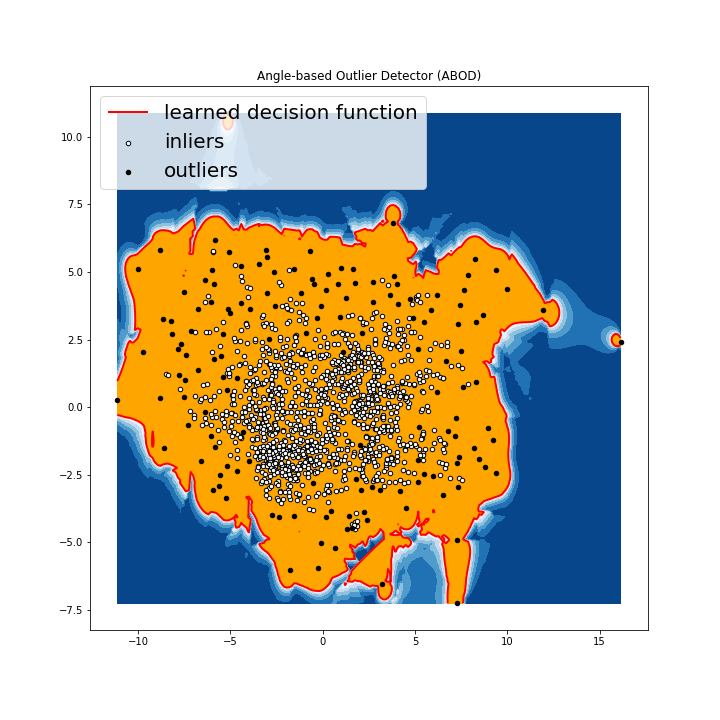

OUTLIERS :  147 INLIERS :  1313 Angle-based Outlier Detector (ABOD)


<IPython.core.display.Javascript object>


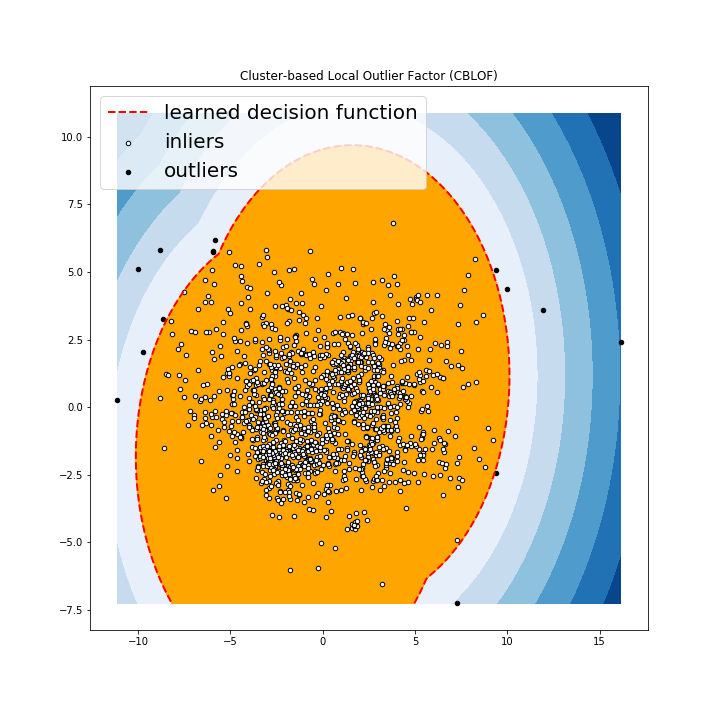

OUTLIERS :  15 INLIERS :  1445 Cluster-based Local Outlier Factor (CBLOF)


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


<IPython.core.display.Javascript object>


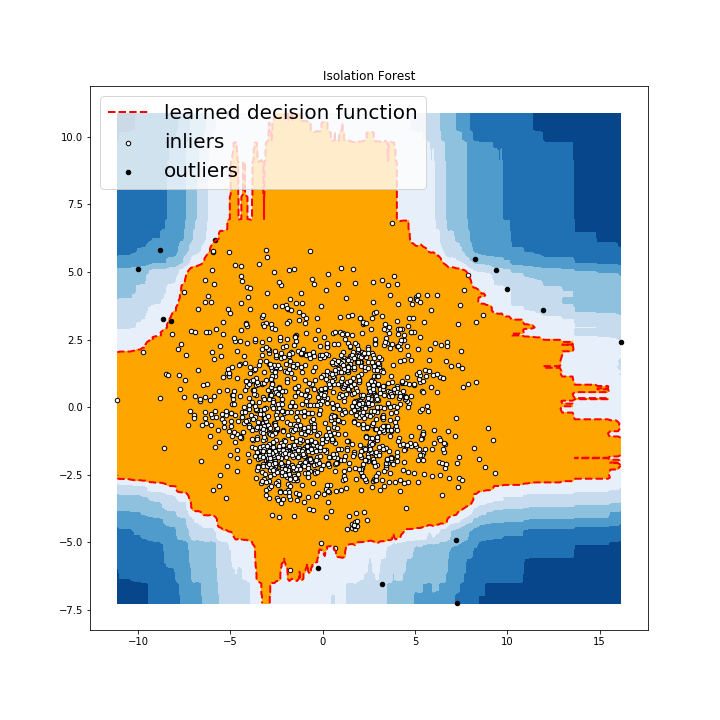

OUTLIERS :  15 INLIERS :  1445 Isolation Forest


<IPython.core.display.Javascript object>


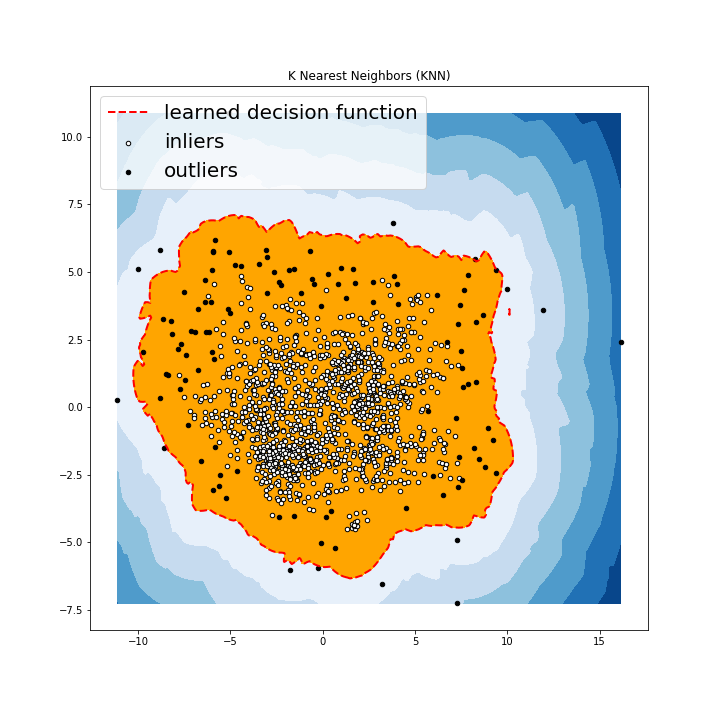

OUTLIERS :  115 INLIERS :  1345 K Nearest Neighbors (KNN)


In [119]:
from scipy import stats

xx , yy = np.meshgrid(np.linspace(np.amin(X_reduced[:,0]), np.amax(X_reduced[:,0]),200), np.linspace(np.amin(X_reduced[:,1]), np.amax(X_reduced[:,1]), 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X_reduced[:,0:2])
    # predict raw anomaly score
    scores_pred = clf.decision_function(X_reduced[:,0:2]) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_reduced[:,0:2])
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = housing
    #dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  X_reduced[y_pred == 0,0]#.reshape(-1,1)
    IX2 =  X_reduced[y_pred == 0,1]#.reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  X_reduced[y_pred == 1,0]#.reshape(-1,1)
    OX2 =  X_reduced[y_pred == 1,1]#.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [ a.collections[0],b,c],
        [ 'learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    #plt.xlim((0, 1))
    #plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

In [85]:
X_reduced[y_pred == 0,0].shape

(1250,)

In [92]:
xx.shape

(200, 200)

## PCA

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

<IPython.core.display.Javascript object>


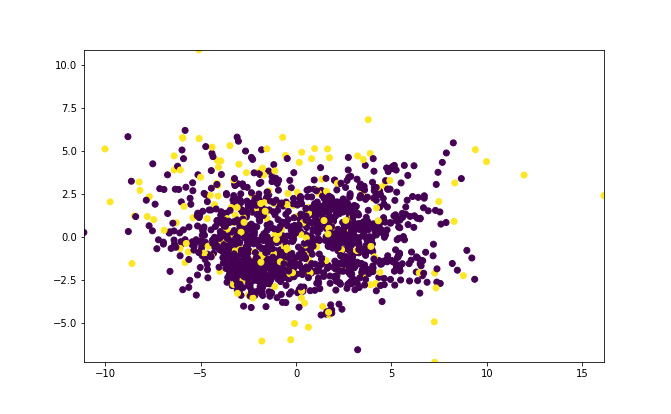

In [89]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_pred)
plt.axis([np.amin(X_reduced[:,0]), np.amax(X_reduced[:,0]), np.amin(X_reduced[:,1]), np.amax(X_reduced[:,1])])
plt.show()


In [155]:
np.amin(X_reduced[:,0]), np.amin(X_reduced[:,1])

(-11.422502325314484, -6.977818769365915)

<IPython.core.display.Javascript object>


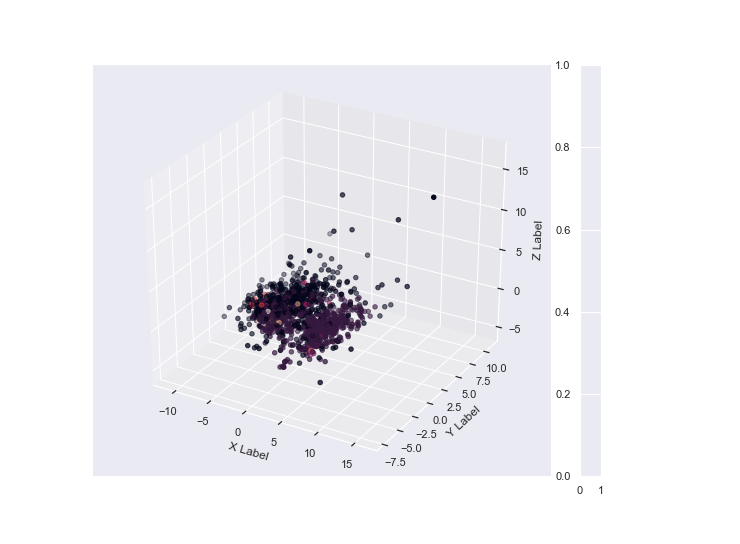

NameError: name 'cmap' is not defined

In [288]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =X_reduced[:,0]
yy =X_reduced[:,1]
z =X_reduced[:,2]



ax.scatter(x, yy,z, c=clusters, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.show()

In [330]:

cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(clusters), vmax=max(clusters))
colors = [cmap(normalize(value)) for value in clusters]





In [218]:
min(y)

34900.0

In [216]:
max(y)

10.629458619203893